In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import pandas as pd
import numpy as np
tf.random.set_seed(1337)

In [ ]:
ds = tfds.load('horses_or_humans', split='train', shuffle_files=True) # load data from online dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incomplete3V3UMN/horses_or_humans-train.tfrecord*..…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incomplete3V3UMN/horses_or_humans-test.tfrecord*...…

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


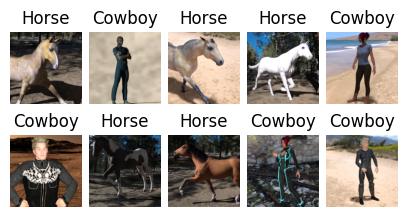

In [ ]:
# plot images from the training set
examples = ds.take(10)
fig = plt.figure(figsize=(5,20))
fig.subplots_adjust(hspace=0.1,wspace=0.1)

# horse = 0, cowboy = 1
for i, ex in enumerate(examples):
  label = "Horse" if ex['label'] == 0 else "Cowboy"
  curr_ax = fig.add_subplot(15, 5, i+1)
  curr_ax.axis("off")
  curr_ax.imshow(ex['image'])
  curr_ax.set_title(label)


In [ ]:
# build the model with convolutional layers
model = models.Sequential()

# kernel, (kernel width, kernel height)
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.ReLU())
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
(ds_train, ds_test), info = tfds.load('horses_or_humans', split=['train', 'test'], with_info=True, shuffle_files=True)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

In [ ]:
def normalize_img(data):
  """Normalizes images: `uint8` -> `float32`."""
  image = data['image']
  label = data['label']
  return tf.squeeze(tf.cast(image, tf.float32) / 255.), label

# normalize each image
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# cache (for quick access) then shuffle elements
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)

# each training batch is 128 elements
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


In [ ]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.fit(ds_train, epochs=3)

Epoch 1/3
9/9 [==============================] - 215s 23s/step - loss: 1.5018 - accuracy: 0.5414
Epoch 2/3
9/9 [==============================] - 197s 21s/step - loss: 0.3931 - accuracy: 0.8724
Epoch 3/3
9/9 [==============================] - 180s 20s/step - loss: 0.2771 - accuracy: 0.8812


In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.shuffle(info.splits['test'].num_examples)
ds_test = ds_test.batch(1)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
model.evaluate(ds_test)

256/256 [==============================] - 24s 90ms/step - loss: 0.3420 - accuracy: 0.9062


[0.34195902943611145, 0.90625]

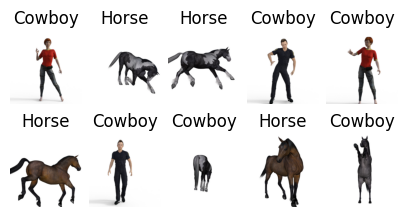

In [ ]:
test_subset = ds_test.take(10)

fig = plt.figure(figsize=(5,20))
fig.subplots_adjust(hspace=0.1,wspace=0.1)

# horse = 0, cowboy = 1
for i, ex in enumerate(test_subset):
  pred = model.predict(ex[0], verbose=0)
  label = "Horse" if pred[0] < 0.5 else "Cowboy"
  curr_ax = fig.add_subplot(15, 5, i+1)
  curr_ax.axis("off")
  curr_ax.imshow(ex[0][0])
  curr_ax.set_title(label)

In [ ]:
model.save("horses_or_cowboys_v3.h5")